## 🛠️ Mod5 Data Challenge 1: ETL-in-the-Wild — Cleaning Civic Data for Product Insights

### 🎯 Purpose

Practice applying the "Transform" step of an ETL pipeline using a real-world dataset—NYC 311 Service Requests. You’ll clean, standardize, and engineer features to prep the data for downstream analysis and business reporting.

### 📚 KSBs

K14 – Strategic feature engineering to improve analysis outcomes

S5 – Data transformation techniques in Python

S8 – Uses Pandas for EDA and data manipulation

B4 – Exercises critical judgment about data quality and reliability

B6 – Pursues deeper insights beyond surface-level observations

### Data
Use the **nyc311.csv** file located in your Github's `data` folder within Mod5/DataChallenges.  This is a sample of the originial file looking at just one week of data since the dataset is HUGE.  Read more about the columns [HERE](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data).   

### 👩‍🏫 Instructor-Led Demo (15 minutes)

#### Step 1:  Load + Preview 
* Read in data

* Show .head(), .info() to examine structure and datatypes

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod5/DataChallenges/data/nyc311.csv')

#### Step 2:  Clean up Categorical Variable 

* Normalize Borough & Complaint Type (e.g., strip whitespace, title-case or upper-case values)

* Show .value_counts() before and after cleaning

In [5]:
# Strip whitespace and standardize case
for col in ["Complaint Type", "Borough"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# pick a style (title-case often reads nicely)
df["Complaint Type"] = df["Complaint Type"].str.title()
df["Borough"] = df["Borough"].str.title()

# quick sanity checks
display(df["Complaint Type"].value_counts().head(10))
display(df["Borough"].value_counts())

Complaint Type
Illegal Parking            10654
Noise - Residential         6603
Noise - Street/Sidewalk     4532
Blocked Driveway            3002
Unsanitary Condition        1539
Noise - Commercial          1411
Dirty Condition             1176
Abandoned Vehicle           1050
Street Condition            1032
Noise                       1023
Name: count, dtype: int64

Borough
Brooklyn         17102
Queens           14668
Manhattan        11729
Bronx            10041
Staten Island     2226
Unspecified         49
Name: count, dtype: int64

#### Step 3:  Feature Engineering

* Convert Created Date to datetime

* Create a new feature: is_weekend based on weekday

In [6]:
df["Created Date"] = pd.to_datetime(df["Created Date"], errors="coerce")

# is_weekend flag
df["is_weekend"] = df["Created Date"].dt.dayofweek >= 5

### 👩‍💻 Student-Led Section (30 minutes)

#### Task1:  Clean & Filter

* Drop rows with missing Created Date or Closed Date

* Drop duplicate rows

* Filter data to only include one borough (e.g., Brooklyn)

In [11]:
# 1a) Drop rows with missing Created/Closed Date
df = df.dropna(subset=["Created Date", "Closed Date"])

# 1b) Drop duplicates
df = df.drop_duplicates()

# 1c) Filter to a single borough (STUDENT CHOICE)
borough_name = "Queens"  # e.g., "Brooklyn"
df_b = df[df["Borough"] == borough_name].copy()
df_b.shape

(11509, 42)

#### Task2:  Time Transformations 

* Create a new column `response_time_hrs` = difference between Closed Date and Created Date (in hours)

* Ensure datetime types are properly parsed and timezone-aware (localize to America/New_York → convert to UTC)

In [12]:
# RUN THIS CELL WITHOUT CHANGES!!!! 

LOCAL_TZ = "America/New_York"

def to_utc(series, local_tz=LOCAL_TZ):
    # 1) parse
    s = pd.to_datetime(series, errors="coerce")

    # 2) if naive -> localize; if tz-aware -> skip (KEEP NONE in this if statement)
    if s.dt.tz is None:
        s = s.dt.tz_localize(local_tz, nonexistent="shift_forward", ambiguous="NaT")

    # 3) convert whatever tz it has to UTC
    return s.dt.tz_convert("UTC")

In [14]:
# Convert both columns to utc
df_b["Created Date"] = to_utc(df_b["Created Date"])
df_b["Closed Date"]  = to_utc(df_b["Closed Date"])

# Now compute the response time
delta = df_b["Closed Date"] - df_b["Created Date"]
df_b["response_time_hrs"] = delta.dt.total_seconds() / 3600

# Check the data with a .head()
df_b[["Created Date", "Closed Date", "response_time_hrs"]].head()

,Created Date,Closed Date,response_time_hrs
7,2025-09-17 05:49:53+00:00,NaT,NaN
37,2025-09-17 05:33:27+00:00,NaT,NaN
50,2025-09-17 05:26:39+00:00,NaT,NaN
69,2025-09-17 05:14:11+00:00,NaT,NaN
74,2025-09-17 05:09:02+00:00,NaT,NaN


#### Task3:  Feature Engineer

* Create `hour_of_day` from Created Date

* Create `is_high_priority`: True if Complaint Type is in a list of priority complaints (e.g., ["HEAT/HOT WATER", "ELECTRIC", "STRUCTURAL"])

In [26]:
# hour_of_day from Created Date 
df_b["hour_of_day"] = df_b["Created Date"].dt.hour

# define a high-priority list (STUDENT CHOICE)
priority_list = ["Heat/Hot Water","Electric","Elevator","Structural"]  # e.g., ["Heat/Hot Water","Electric","Elevator","Structural"]
df_b["is_high_priority"] = df_b["Complaint Type"].isin(priority_list)

display(df_b[["Complaint Type","hour_of_day","is_high_priority"]].head(10))

,Complaint Type,hour_of_day,is_high_priority
7,Homeless Person Assistance,5,False
37,Blocked Driveway,5,False
50,Non-Emergency Police Matter,5,False
69,Homeless Person Assistance,5,False
74,Illegal Parking,5,False
89,Noise - Street/Sidewalk,5,False
96,Noise - Vehicle,4,False
103,Noise - Residential,4,False
111,Noise - Street/Sidewalk,4,False
114,Illegal Parking,4,False


#### Task4:  Aggregates & Visuals 

* Average response time by Complaint Type (sorted descending)

* Total number of complaints by hour_of_day (bar chart)

In [18]:
# Average response time by complaint type (descending)
avg_resp = df_b.groupby("Complaint Type")["response_time_hrs"].mean().sort_values(ascending=False)

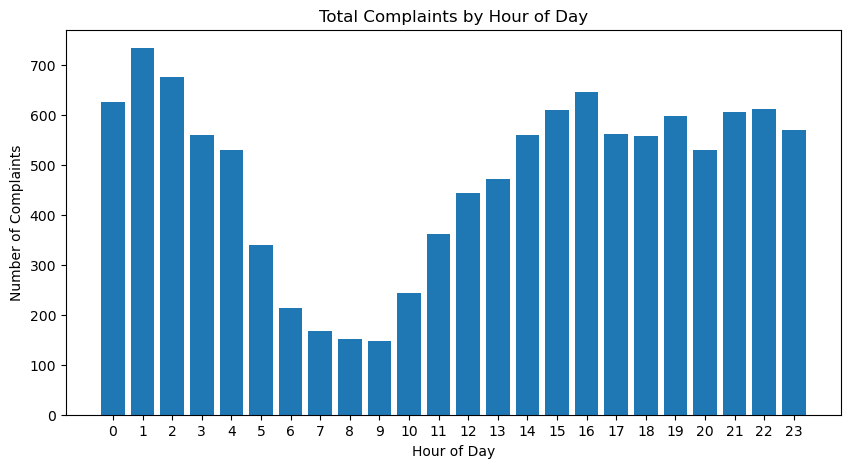

In [20]:
# Total complaints by hour_of_day (bar chart)
import matplotlib.pyplot as plt

# Group by hour_of_day and count complaints
total_complaints = df_b.groupby("hour_of_day")["Complaint Type"].count()

# Plot
plt.figure(figsize=(10,5))
plt.bar(total_complaints.index, total_complaints.values)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Complaints')
plt.title('Total Complaints by Hour of Day')
plt.xticks(range(0,24))  
plt.show()


#### Notebook Reflection

Answer the questions in a markdown cell below.  Be thorough (no need to use AWES just answer the question fully)

1. Describe one transformation or feature you engineered (e.g., response_time_hrs, is_high_priority) and explain why it would be useful for a city analyst or operations manager.
- One transformation I created was response_time_hrs, which calculates how long it takes for the city to respond to a complaint. This feature is useful because it allows us to measure the efficiency of 311 services. For example, city analysts can identify which complaint types take the longest to resolve (e.g., elevator or heating issues) and use that insight to allocate more resources or adjust policies. Operations managers can also monitor service reliability over time and ensure residents are receiving timely responses.
2. What could go wrong if you didn’t clean the datetime fields properly or skipped removing rows with missing Closed Date? How might that distort future dashboards or decisions?
- If datetime fields aren’t cleaned properly, the calculated response times may be inaccurate or misleading. For example, a missing or malformed Closed Date could result in negative or extremely large response times, which would distort averages. If these errors go unnoticed, dashboards might falsely suggest that certain complaints are resolved instantly or take weeks longer than they actually do. Decision-makers relying on this data might then misallocate resources or fail to identify true service delays, ultimately lowering trust in the system.

### 📣 Class Share-Out (15 minutes)

Be ready to share out the following points with the class: 

📣 Explain:

How average response_time_hrs by complaint type offers insight (e.g., “Elevator complaints take longer to resolve”)

What does your chosen borough trends reveal (e.g., “Most heating complaints come in before 10am”)

🛠️ Propose:

One next transformation step you would include in the full data pipeline (e.g., flagging overdue requests)

